In [33]:
%matplotlib inline
from ml import plots
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
plots.set_plot_style()
discrete_cmap = LinearSegmentedColormap.from_list('discrete', colors = [(0.8, 0.2, 0.3), (0.98, 0.6, 0.02), (0.1, 0.8, 0.3), (0, 0.4, 0.8), ], N=4)


# Neural Networks and Deep Learning


## Linear Classification II

Previously we talked about classification using a linear function $f(x): \mathbb{R}^{p} \to \mathbb{R}$ and least-square regression.

Recall the linear function dependent on the paramter vector $\beta$


$$
f(x)= \hat{y} =  \hat{\beta}_0 + \sum_{j=1}^p x_j \hat{\beta}_j
$$


$$
f(x)= \hat{y} =  x^T \mathbf{\beta}
$$

where $\beta = (\beta_0, \beta_1, \beta_2, \ldots, \beta_p)$ and $x = (1, x_1, x_2, \ldots, x_p)$.

We minimized the residual sum of squares using matrix multiplication.

$$
RSS(\beta) = (\mathbf{y} - \mathbf{X} \beta)^T (\mathbf{y} - \mathbf{X} \beta )
\Rightarrow \hat{\beta} = (\mathbf{X}^T \mathbf{X})^{-1} \mathbf{X}^T \mathbf{y}
$$


In order to perform the classification we had to define the classification function 

$$
\hat{y} = \begin{cases}
\text{Yes}, & \text{if $ f(x) \gt 0.5$} \\
\text{No}, & \text{if $ f(x) \le 0.5$}
\end{cases}
$$ 

Now we encode the class label directly into the function. Given a classification problem with $K$ different classes we want $f(x): \mathbb{R}^{p} \to \mathbb{R}^K$ to return a vector of length $K$. Instead of finding the parameters in a vector $\beta$ we use a $K \times p$ matrix $\mathbf{W}$

$$
f(x) = \hat{y} =   \mathbf{W} x
$$

At this point we could again minimize a modified version of the RSS or the SVM loss. This time however we want to be able to have a more *probabilistic* intepretation of the loss function.

We use a new loss function called the __cross-entropy loss__. Given two probability density functions $p$ and $q$ over the same probabilistic space,  cross entropy is defined as

$$
H_{\times}(p, q) =     -\sum _{x} p(x)\,\log q(x).\!
$$

The cross entropy gives smaller values for similar distributions $q$ and $p$.
In case of classification problems $p$ is the true distribution of classes for a given $x$ and $q(x)$ the estimated distribution as produced by our machine learner. 

In the example below we look at $p$ for the digits dataset. As one example in the dataset can be just one digit, the $p$ vector has only a single non-zero entry. 

If a classifier produces the same distribution for the dataset we have perfect classification.

True (discrete) probability distributions.
[0 0 0 0 0 1 0 0 0 0]
[0 0 0 0 0 0 1 0 0 0]
[0 0 0 0 0 0 0 1 0 0]
[0 0 0 0 0 0 0 0 1 0]
[0 0 0 0 0 0 0 0 0 1]
[1 0 0 0 0 0 0 0 0 0]
[0 1 0 0 0 0 0 0 0 0]
[0 0 1 0 0 0 0 0 0 0]
[0 0 0 1 0 0 0 0 0 0]
[0 0 0 0 1 0 0 0 0 0]


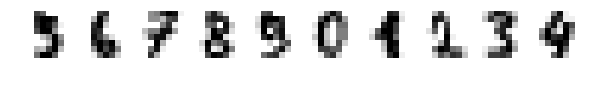

In [34]:
from sklearn.datasets import load_digits
from sklearn import preprocessing
X, y = load_digits(return_X_y=True)

y = preprocessing.LabelBinarizer().fit_transform(y)

print('True (discrete) probability distributions.')

fig, axs = plt.subplots(1, 10, figsize=(10, 10))
for i, x_i in enumerate(X[5:15]):
    ax = axs[i]
    img = x_i.reshape(8, 8)
    ax.imshow(img, cmap='gray_r', interpolation='nearest')
    ax.axis('off')
    print(y[i+5])

We want our estimated probabilities for the distribitution of class labels to be as close to the true distribution as possible. The result of our function $f(x)$ does not produce probability estimates. We need to *transform the results to probabilities* using the so called __softmax__ function

\begin{align}
q_k(x) =& −\log\left( \frac{e^{f_{k}(x)}} {∑_j e^{f_j(x)}} \right) \\
q_k(x) =& −f_{k}(x) + \log\left(∑_j e^{f_k(x)}\right)
\end{align}

where the index $j \in \{1, \ldots, K \}$ loops over all classes and $f_k$ is the prediction for class $k$.

In shorter words: A classifier using cross entropy loss with softmax produces probabilities for class memberships.

In the example below we minimize the cross entropy with softmax to classifiy the digits dataset.

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/base.py:347: RuntimeWarning: invalid value encountered in true_divide
  prob /= prob.sum(axis=1).reshape((prob.shape[0], -1))


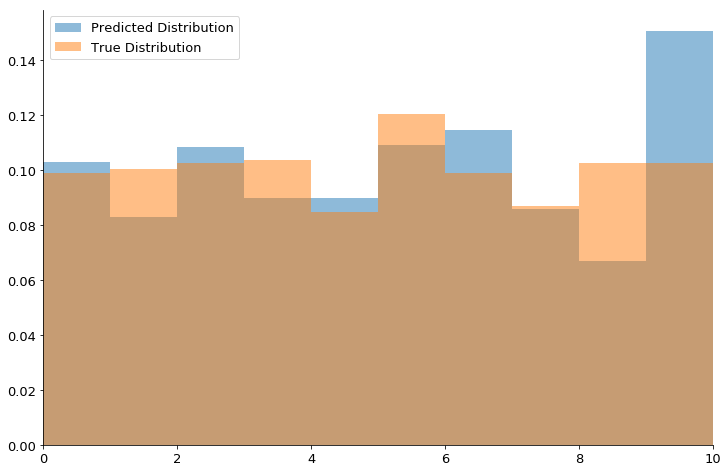

In [61]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
X, y = load_digits(return_X_y=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

y_test = preprocessing.LabelBinarizer().fit_transform(y_test)

clf = SGDClassifier(max_iter=50, tol=1E-4,  loss='log', random_state=0).fit(X_train, y_train)
y_prediction = clf.predict_proba(X_test)

plt.bar(range(10), np.nansum(y_prediction, axis=0)/np.nansum(y_prediction), width=1, align='edge', alpha=0.5, label='Predicted Distribution')
plt.bar(range(10), np.nansum(y_test, axis=0)/np.nansum(y_test), width=1, align='edge', alpha=0.5, label='True Distribution')
plt.legend()
plt.margins(x=0)